### Import Data


In [1]:
import pandas as pd 

spam_df = pd.read_csv('url_spam.csv')
spam_df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


### Transform 

In [2]:
spam_df['is_spam'] = spam_df['is_spam'].astype(str).apply(lambda x: 1 if x == 'True' else 0).astype(int)
print(spam_df)

                                                    url  is_spam
0     https://briefingday.us8.list-manage.com/unsubs...        1
1                                https://www.hvper.com/        1
2                    https://briefingday.com/m/v4n3i4f3        1
3      https://briefingday.com/n/20200618/m#commentform        0
4                           https://briefingday.com/fan        1
...                                                 ...      ...
2994  https://www.smartcitiesworld.net/news/news/dee...        0
2995                      https://www.youtube.com/watch        1
2996  https://techcrunch.com/2019/07/04/an-optimisti...        0
2997  https://www.technologyreview.com/2019/12/20/13...        0
2998       https://www.bbc.com/news/technology-51018758        0

[2999 rows x 2 columns]


In [3]:
unique_values = spam_df['is_spam'].value_counts()
print(unique_values)

is_spam
0    2303
1     696
Name: count, dtype: int64


In [4]:
spam_df = spam_df.drop_duplicates()
spam_df = spam_df.reset_index(inplace=False, drop = True)
spam_df.shape

(2369, 2)

In [5]:
%pip install regex
import regex as re

def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

spam_df["url"] = spam_df["url"].apply(preprocess_text)
spam_df.head()

Note: you may need to restart the kernel to use updated packages.


,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


### Lemmetization 

In [6]:
#%pip install nltk
from nltk import download 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 

download("wordnet")
lemmatizer = WordNetLemmatizer()


download('stopwords')
stop_words = set(stopwords.words('english'))

def lemmatize_text(words, lemmatizer = lemmatizer):
    text = [lemmatizer.lemmatize(word) for word in words]
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word) > 3]
    return text

spam_df['url'] = spam_df['url'].apply(lemmatize_text)
spam_df.head()
    


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


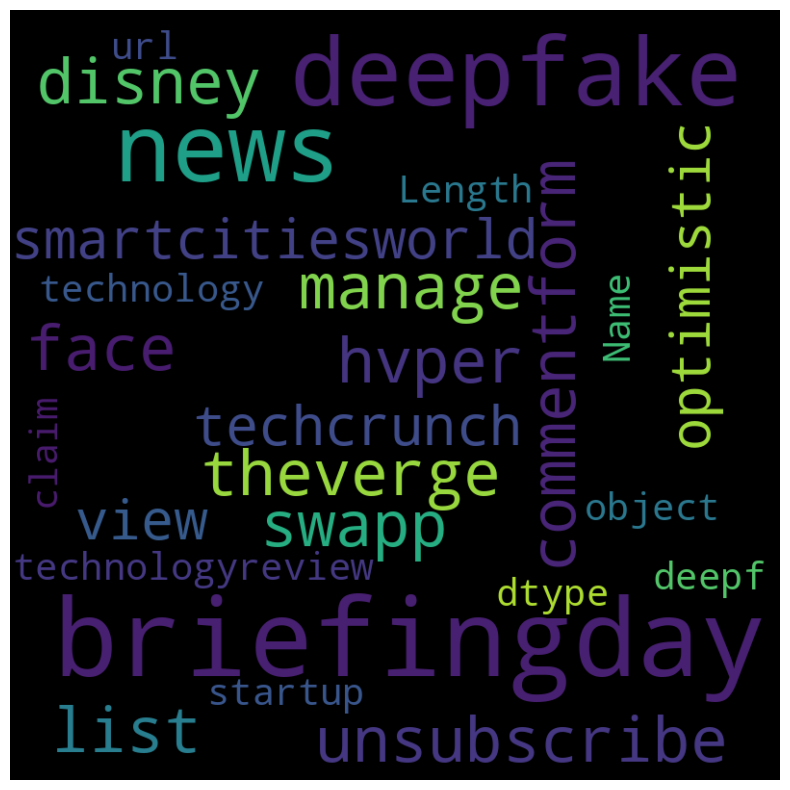

In [7]:
#%pip install wordCloud
import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

wordcloud = WordCloud(width=800, height=800, background_color='black', max_words = 1000, min_font_size = 20, random_state=42).generate(str(spam_df['url']))


# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()


### Convert Categories to 0 and 1

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_list = spam_df['url']
text_list = [" ".join(text) for text in text_list]

vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)

X = vectorizer.fit_transform(text_list).toarray()
y = spam_df['is_spam']



In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create SVM model

In [10]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 

#initialize and fit
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)


SVC(kernel='linear')

In [11]:
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9514767932489452


### Grid Search


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],   # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'kernel': ['rbf', 'linear', 'poly']  # Kernel type
}

grid_serach = GridSearchCV(estimator=svm, param_grid=param_grid, cv=10)
grid_serach.fit(X_train, y_train)

print("Best Parameters: ", grid_serach.best_params_)

Best Parameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [13]:
svm_grid = SVC(kernel = 'rbf', C = 10, gamma=1)
svm_grid.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [14]:
y_pred_grid = svm_grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_grid)
print(accuracy)

0.9556962025316456


### Decision Boundary

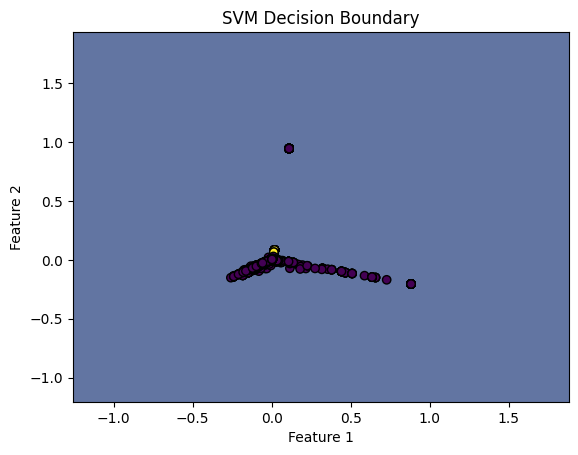

In [18]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# Reduce dimensionality to 2 features for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Train SVM on the PCA-transformed data
svm_pca = SVC(kernel='linear')  # or any other kernel
svm_pca.fit(X_pca, y)

# Create a mesh to plot the decision boundary
h = .02  # Step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the decision boundary
Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary')
plt.show()